In [33]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import random

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [7]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [11]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

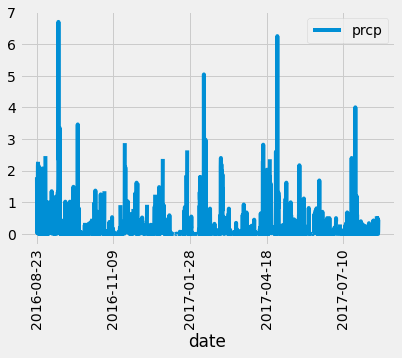

In [30]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
result = session.query(Measurement.date).\
order_by(Measurement.date.desc()).first()
last_date = dt.datetime.strptime(result.date, '%Y-%m-%d').date()
year_ago = last_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
stmt = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_ago).statement

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.read_sql_query(stmt, session.bind)
df.set_index('date', inplace=True)
df.head(10)

# Sort the dataframe by date
df = df.sort_values('date')
# Use Pandas Plotting with Matplotlib to plot the data
df.plot(rot=90)



In [26]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.agg(['mean', 'median', 'var', 'std', 'sem'])
df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [15]:
# Design a query to show how many stations are available in this dataset?
x = session.query(Station.station).count()
x

9

In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active = session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).\
order_by(desc(func.count((Measurement.station)))).all()
active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
highest = active[0][0]
highest_temp = session.query(Measurement.tobs).filter(Measurement.station == highest).order_by(desc(Measurement.tobs)).first()
lowest_temp = session.query(Measurement.tobs).filter(Measurement.station == highest).order_by(Measurement.tobs).first()
avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == highest).all()
avg_temp

[(71.66378066378067)]

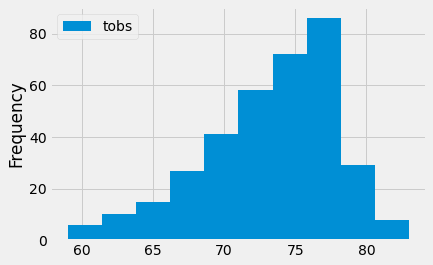

In [25]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# df.loc[df['station'] == highest]
stmt = session.query(Measurement.date, Measurement.tobs, Measurement.station).filter(Measurement.date >= year_ago).statement
df2 = pd.read_sql_query(stmt, session.bind)
df2.set_index('date', inplace=True)
df2.head(10)
df2.loc[df2['station']==highest].plot.hist()

## Bonus Challenge Assignment

In [27]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [35]:
df

,prcp
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


In [41]:
time_between_dates = last_date - year_ago
days_between_dates = time_between_dates.days
random_number_of_days = random.randrange(days_between_dates)
random_date = start_date + dt.timedelta(days=random_number_of_days)
vac_start = random_date 
vac_end = vac_start + dt.timedelta(days=7)
print(vac_start, vac_end)


2016-08-30 2016-09-06


In [54]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
vac_temp = calc_temps(vac_start, vac_end)
(tmin, tavg, tmax) = vac_temp[0]

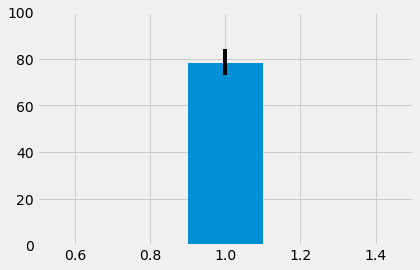

In [116]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
x=1
y=tavg
plt.subplots(1, 1)
plt.bar(x, y, width=0.2)
plt.xlim(0.5, 1.5)
plt.ylim(0, 100)
plt.errorbar(1, (tmin, tmax), color='black')
plt.show()

In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
